In [1]:
# Set up environment
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

import matplotlib.pyplot as plt

import torch
import numpy as np

from body_visualizer.tools.vis_tools import render_smpl_params
from body_visualizer.tools.vis_tools import imagearray2file, show_image

In [2]:
#This tutorial requires 'vposer_v2_05'

from os import path as osp
vposer_dir = './backbones/human_body_prior'
support_dir = vposer_dir + '/support_data/dowloads'
expr_dir = osp.join(support_dir,'vposer_v2_05') #'TRAINED_MODEL_DIRECTORY'  in this directory the trained model along with the model code exist
bm_fname =  osp.join(support_dir,'models/smplx/SMPLX_NEUTRAL.npz') #'PATH_TO_SMPLX_model.npz'  obtain from https://smpl-x.is.tue.mpg.de/downloads

print(expr_dir)
print(bm_fname)

./backbones/human_body_prior/support_data/dowloads/vposer_v2_05
./backbones/human_body_prior/support_data/dowloads/models/smplx/SMPLX_NEUTRAL.npz


In [3]:
#Loading SMPLx Body Model
from human_body_prior.body_model.body_model import BodyModel

bm = BodyModel(bm_fname=bm_fname).to('cuda')

In [4]:
#Loading VPoser Body Pose Prior
from human_body_prior.tools.model_loader import load_model
from human_body_prior.models.vposer_model import VPoser
vp, ps = load_model(expr_dir, model_code=VPoser,
                              remove_words_in_model_weights='vp_model.',
                              disable_grad=True)
vp = vp.to('cuda')

2023-06-27 15:07:21.697 | INFO     | human_body_prior.tools.model_loader:load_model:97 - Loaded model in eval mode with trained weights: ./backbones/human_body_prior/support_data/dowloads/vposer_v2_05/snapshots/V02_05_epoch=13_val_loss=0.03.ckpt


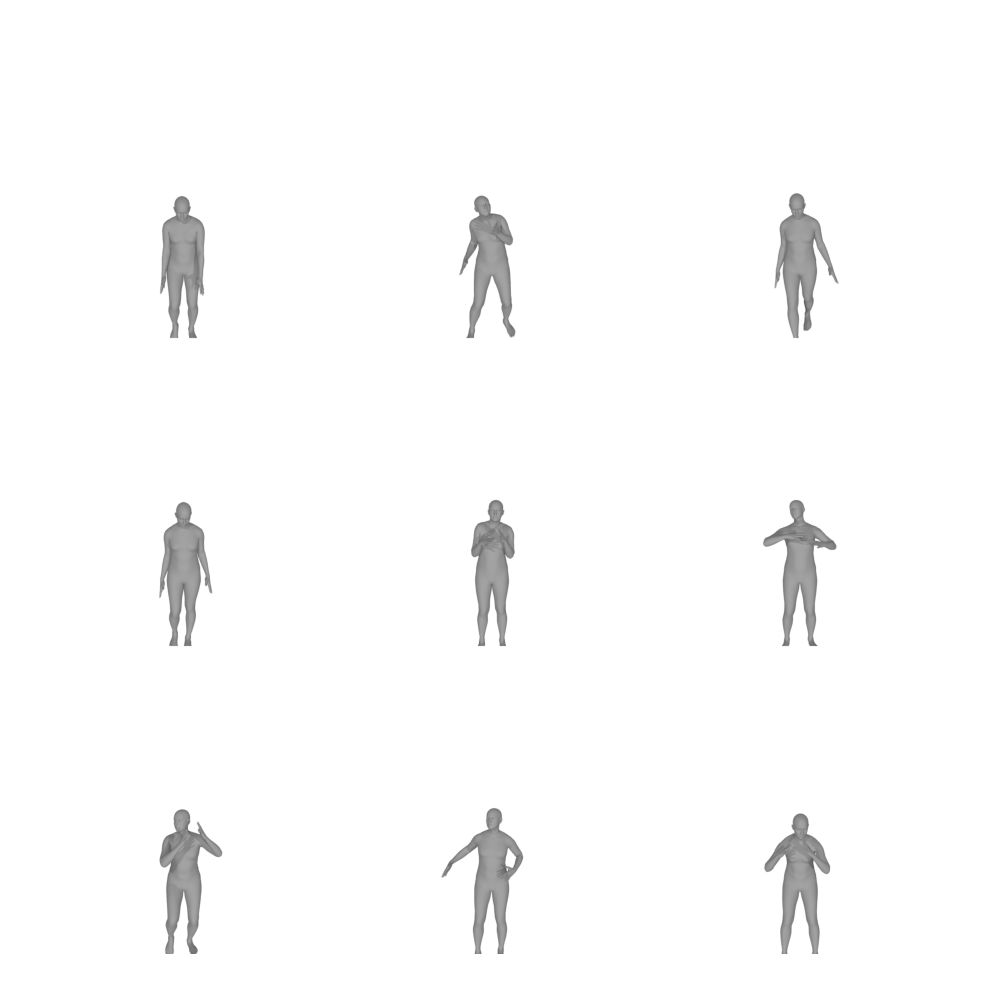

In [5]:
# joint_names = {       
#             0: 'L_Hip',
#             3: 'L_Knee',
#             6: 'L_Ankle',
#             9: 'L_Foot',
         
#             1: 'R_Hip',
#             4: 'R_Knee',
#             7: 'R_Ankle',
#             10: 'R_Foot',
         
#             2: 'Spine1',
#             5: 'Spine2',
#             8: 'Spine3',
#             11: 'Neck',
#             14: 'Head', # 15?
         
#             12: 'L_Collar',
#             15: 'L_Shoulder',
#             17: 'L_Elbow',
#             19: 'L_Wrist',
#             13: 'R_Collar',
#             16: 'R_Shoulder',
#             18: 'R_Elbow',
#             20: 'R_Wrist',
#         }

# Generate 3D poses
num_poses = 9 
sampled_pose_body = vp.sample_poses(num_poses=num_poses)['pose_body'].contiguous() # generate Nx1x21x3 tensor of body pose parameters

plot_pose_body = {'pose_body':sampled_pose_body.view(num_poses, -1)}
body = bm(**plot_pose_body) # fwd pass to regress the kpts in xyz
plot_poses = body.Jtr.cpu().numpy() # retrieve kpts

# Show full smpl pose renders
sampled_pose_body = sampled_pose_body.view(num_poses, -1)
images = render_smpl_params(bm, {'pose_body':sampled_pose_body}).reshape(3,3,1,800,800,3)
img = imagearray2file(images)
show_image(np.array(img[0]))

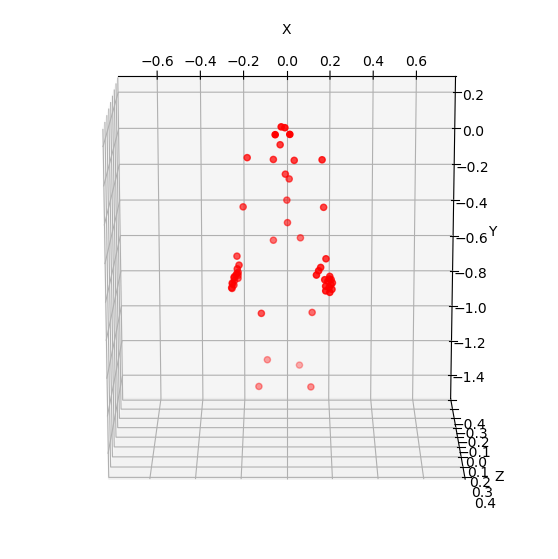

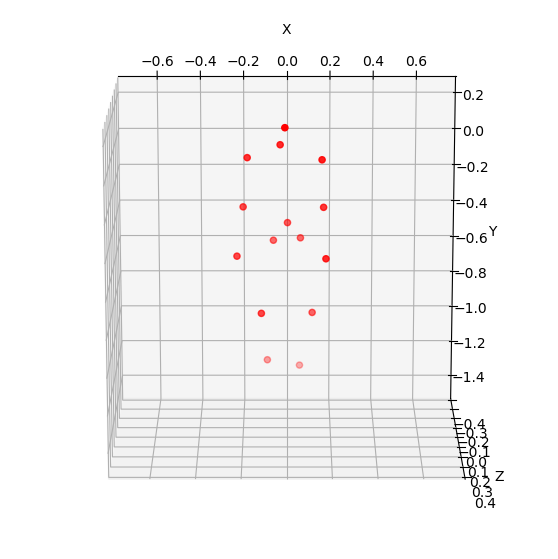

In [6]:
# Full body plot
fig = plt.figure(figsize=(7,7),)
ax = fig.add_subplot(projection='3d')
ax.scatter(plot_poses[0][:,0], plot_poses[0][:,1], plot_poses[0][:,2], c='r', marker='o')
ax.view_init(elev=105., azim=-90)
ax.set_xlabel('X')
ax.set_xlim(-0.75, 0.75)
ax.set_ylabel('Y')
ax.set_ylim(-1.5, 0.25)
ax.set_zlabel('Z')
ax.set_zlim(-0.4, 0.4)
plt.show()

# AP kpt subset plot
ap_idxs = [
        0, # Pelvis
        2,5,8,  # RL
        1,4,7,  # LL

        12,15,  # Neck, Head

        17,19,21,   # RA
        16,18,20    # LA

        # 10,11 # L Foot, R Foot 
        # 3,6,9,  # Spine
        # 13,14 # L Collar, R Collar
        ]
plot_ap_poses = plot_poses[:,ap_idxs]   # exclude hand joints, and include AP comparable kpts

fig = plt.figure(figsize=(7,7),)
ax = fig.add_subplot(projection='3d')
ax.scatter(plot_ap_poses[0][:,0], plot_ap_poses[0][:,1], plot_ap_poses[0][:,2], c='r', marker='o')
ax.view_init(elev=105., azim=-90)
ax.set_xlabel('X')
ax.set_xlim(-0.75, 0.75)
ax.set_ylabel('Y')
ax.set_ylim(-1.5, 0.25)
ax.set_zlabel('Z')
ax.set_zlim(-0.4, 0.4)
plt.show()

# Pose Lifter

In [28]:
from backbones.auto_UPDRS.models import body_pose

def fix_model_setup(in_ckpt_path, out_dict_path):
    '''
    Helper to fix the model setup
    '''
    # load the pretrained model in Mohsens setup
    model = body_pose.Lifter()    # CHANGE THIS AS NECESSARY
    dict = torch.load(in_ckpt_path).state_dict()
    model.load_state_dict(dict)
    # Fix the setup by only saving the state_dict
    torch.save(model.state_dict(), out_dict_path)
    print("Saved new", out_dict_path)

# fix the setup
in_ckpt_path = './backbones/auto_UPDRS/model_checkpoints/body_pose/mohsen_models/model_pretrain.pt' # model_pretrain, model_lifter, 
out_dict_path = './backbones/auto_UPDRS/model_checkpoints/body_pose/mvp_3D_h36m.pth'

fix_model_setup(in_ckpt_path, out_dict_path)

Saved new ./backbones/auto_UPDRS/model_checkpoints/body_pose/mvp_3D_h36m.pth


In [10]:
def reorder_kpts(kpts):
    '''
    Change from SMPL kpt ordering to lifter input ordering
    '''
    smpl_out_ordering = {
        'LA': [12, 13, 14], # L Arm:  Neck, LShoulder, LElbow, LWrist
        'RA': [9, 10, 11],  # R Arm:  Neck, RShoulder, RElbow, RWrist
        'LL': [1, 2, 3],    # L Leg:  Hip, LHip, LKnee, LAnkle
        'RL': [4, 5, 6],    # R Leg:  Hip, RHip, RKnee, RAnkle
        'T': [8, 7, 0],        # Torso:  Head, Neck, Hip
    }
    lifter_in_ordering = {
        'LA': [12,13,14], # L Arm:  Neck, LShoulder, LElbow, LWrist
        'RA': [9,10,11],  # R Arm:  Neck, RShoulder, RElbow, RWrist
        'LL': [1,2,3],    # L Leg:  Hip, LHip, LKnee, LAnkle
        'RL': [4,5,6],    # R Leg:  Hip, RHip, RKnee, RAnkle
        'T':  [8,7,0],        # Torso:  Head, Neck, Pelvis
    }

    # reorder
    kpts_out = np.zeros((kpts.shape[0], 15, 3))
    for i, (key, val) in enumerate(smpl_out_ordering.items()):
        kpts_out[:, lifter_in_ordering[key]] = kpts[:, smpl_out_ordering[key]]
    
    # print(kpts[0])
    # print(kpts_out[0])
    return kpts_out
    

def process_3D_poses_for_lifter(poses_3d):
    '''
    Prepare 2D pose samples for lifting from the generated 3D poses
    '''
    inp_poses_2d = poses_3d.copy()
    inp_poses_2d = reorder_kpts(inp_poses_2d) # reorder
    inp_poses_2d = inp_poses_2d[:,:,:2]   # 3D->2D weak reprojection
    inp_poses_2d -= inp_poses_2d[:,:1,:]  # center to pelvis
    inp_poses_2d = inp_poses_2d.reshape(inp_poses_2d.shape[0], -1, order='F') # flatten: (N, xxx ..., yyy ...)
    inp_poses_2d /= np.linalg.norm(inp_poses_2d, axis=1, keepdims=True) # normalize scale

    inp_poses_2d = torch.tensor(inp_poses_2d).float()
    inp_confs_2d = torch.ones((inp_poses_2d.shape[0], 15)).float()

    return inp_poses_2d, inp_confs_2d


In [29]:
from backbones.auto_UPDRS.models import body_pose
from backbones.auto_UPDRS.utils import pose_visualization
from utils import pose_plotting, pose_processing, errors

# Load 3D Lifter
lifter_ckpt_path = './backbones/auto_UPDRS/model_checkpoints/body_pose/mvp_3D_h36m.pth'
lifter = body_pose.Lifter()
lifter.load_state_dict(torch.load(lifter_ckpt_path))
lifter.eval()

# Prepare 2D pose samples
inp_poses_2d, inp_confs_2d = process_3D_poses_for_lifter(plot_ap_poses)

# Inference
with torch.no_grad():
    pred_3d_poses, _ = lifter(inp_poses_2d, inp_confs_2d)


gt_3d_poses = plot_ap_poses.transpose(0,2,1)
gt_3d_poses -= gt_3d_poses[:, :, 0:1]  # center to pelvis
# gt_3d_poses = pose_processing.zero_pose_orient(gt_3d_poses.transpose(0,2,1)).transpose(0,2,1)

pred_3d_poses = pred_3d_poses.reshape(-1, 3, 15).cpu().numpy()
pred_3d_poses -= pred_3d_poses[:, :, 0:1]  # center to pelvis

# pred_3d_poses /= 3

# reorient_poses = torch.tensor([gt_3d_poses[0], pred_3d_poses]).float()
# pred_3d_poses = pose_processing.zero_pose_orient(pred_3d_poses.transpose(0,2,1)).transpose(0,2,1)

pred_3d_poses[:, :, 1:4], pred_3d_poses[:, :, 4:7] = pred_3d_poses[:, :, 4:7], pred_3d_poses[:, :, 1:4].copy()  # Swap pred legs, bc its mohsens old model


# Procrustes align
# gt_3d_poses = torch.tensor(gt_3d_poses).float()
# pred_3d_poses = torch.tensor(pred_3d_poses).float()
# pred_3d_poses = pose_processing.procrustes_torch(gt_3d_poses.transpose(2,1), pred_3d_poses.transpose(2,1)).transpose(0,2,1)

i = 0
pose_plotting.visualize_multi_view_pose([pred_3d_poses[i], gt_3d_poses[i]], 
                                        kpts_2D=[inp_poses_2d[i], inp_poses_2d[i]], 
                                        lifter_in_view=0, 
                                        save_fig=True, out_fig_path="./outputs/pose_lifted.png")

# Calculate errors
n_mpjpe = errors.n_mpjpe(torch.tensor(pred_3d_poses[i]), torch.tensor(gt_3d_poses[i])).item()
print(n_mpjpe)



0.8228039145469666
